### Import packages

In [1]:
import enchant
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import sys

In [ ]:
# Install large model

#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

# Do not use

In [ ]:
# Install medium model
#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

### Load and subset data

In [2]:
df = pd.read_csv("/home/domib/code/dominik-bulla/g0zzy/stress_sense/raw_data/Combined Data.csv", encoding="latin1")

In [ ]:
df.columns

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')

In [3]:
stress_posts = df[df['status'].isin(['Stress','Anxiety','Depression'])]
print(stress_posts.shape)
print(stress_posts.columns)
print(stress_posts.dtypes)
stress_posts.head(200)

(21961, 3)
Index(['Unnamed: 0', 'statement', 'status'], dtype='object')
Unnamed: 0     int64
statement     object
status        object
dtype: object


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
195,195,Do not compare yourself to others. Envy only m...,Anxiety
196,196,"The 5 dream ones were moved to a new unit, so ...",Anxiety
197,197,finished for the heart's intention to watch th...,Anxiety
198,198,"""No regrets or grudges/angry at things that ha...",Anxiety


### Text Preprocessing

In [4]:
### lowercase
### dealing with numbers, punctuation, and symbols
### splitting
### tokenizing
### removing "stopwords"
### lemmatizing

nlp = spacy.load("en_core_web_md", disable=["ner", "parser", "textcat"])

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, language_model=nlp, min_len=1):
        self.nlp = language_model
        self.min_len = min_len  # optional length filter

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess(x) for x in X]

    def _preprocess(self, text):
        # Missing values
        if text is None:
            return []
        if not isinstance(text, str):
            text = str(text)

        # lower case
        text = text.strip().lower()
        if not text:
            return []

        # dealing with numbers, punctuation, and symbols/stopwords/lemmatizing
        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha and not tok.is_stop
        ]

        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha
            and not tok.is_stop
            and len(tok) > 2         # drop very short leftovers
            and tok.lemma_ not in {"don", "t", "m", "feel", "like", "want", "know", "go", "think", "get"}  # custom contraction cleanup
        ]

        # Optional: drop very short results
        if len(tokens) < self.min_len:
            return []
        return tokens

text_pipeline = Pipeline([
    ("preprocessor", TextPreprocessor())
])


In [5]:
processed = text_pipeline.fit_transform(stress_posts["statement"])
b = list(processed)  # in case it's a numpy array
stress_posts = stress_posts.copy()
stress_posts["processed_tokens"] = pd.Series(processed, index=stress_posts.index, dtype=object)

### Text vectorizing

In [25]:
stress_posts["processed_text"] = stress_posts["processed_tokens"].apply(" ".join)

vectorizer = CountVectorizer(
    lowercase=False,
    max_features=1000,
    ngram_range=(2, 3)
)
vectorized_messages = vectorizer.fit_transform(stress_posts["processed_text"])


### Finding best model

In [26]:
scores = []
perplexities = []
topics_range = range(3, 12, 3)

for k in topics_range:
    print(k)
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=100,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(vectorized_messages)
    scores.append(lda.score(vectorized_messages))
    perplexities.append(lda.perplexity(vectorized_messages))

3
6
9


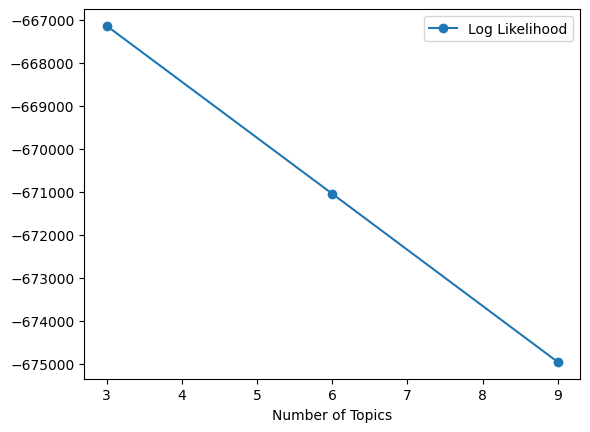

In [27]:
%matplotlib inline

plt.plot(topics_range, scores, marker="o", label="Log Likelihood")
# plt.plot(topics_range, perplexities, marker="x", label="Perplexity")
plt.xlabel("Number of Topics")
plt.legend()
plt.show()


### Train LDA Model

In [15]:
n_components = 6
lda_model = LatentDirichletAllocation(
    n_components=n_components,
    max_iter = 500,
    random_state=42)
lda_model.fit(vectorized_messages)
topics_mixture = lda_model.transform(vectorized_messages)

### link back to original dataframe 

In [16]:
def link_back(topics_mixture, stress_posts):

    topic_cols = [f"topic_{i}" for i in range(topics_mixture.shape[1])]
    topic_df = pd.DataFrame(topics_mixture, index=stress_posts.index, columns=topic_cols)

    stress_posts = stress_posts.copy()
    stress_posts["dominant_topic"] = topic_df.values.argmax(axis=1)
    stress_posts["dominant_weight"] = round(topic_df.max(axis=1),2)
    stress_posts["solution"] = np.where(
        stress_posts["dominant_weight"] > round(1/6,2), 1, 0
    )

    return stress_posts

In [17]:
stress_posts = link_back(topics_mixture, stress_posts)

In [18]:
### proportion of proper solutions
print(round(np.multiply(stress_posts.solution.value_counts(normalize=True)[1], 100),2))


99.06


In [24]:
stress_posts[
    (stress_posts['status'] == "Anxiety") &
    (stress_posts['solution'] == 1)
]["dominant_topic"].value_counts()


dominant_topic
5    2874
0     295
1     274
3     184
2     146
4      59
Name: count, dtype: int64

In [20]:
def print_topics(lda_model, vectorizer, top_words):
    topic_word_mixture = pd.DataFrame(
        lda_model.components_,
        columns = vectorizer.get_feature_names_out()
    )
    n_components = topic_word_mixture.shape[0]

    for topic in range(n_components):
        print("-"*10)
        print(f"For topic {topic}, here are the the top {top_words} words with weights:")

        topic_df = topic_word_mixture.iloc[topic]\
            .sort_values(ascending = False).head(top_words)

        print(round(topic_df,3))

In [21]:
print_topics(lda_model, vectorizer, 20)


----------
For topic 0, here are the the top 20 words with weights:
depression       4840.810
help             3940.731
anxiety          3064.037
stress           2071.401
mental           1972.020
health           1638.729
therapy          1560.541
work             1433.179
need             1424.131
try              1349.888
take             1262.883
medication       1162.862
year             1120.766
bad              1106.460
time             1074.451
mental health    1062.162
experience       1051.779
therapist         995.037
med               916.234
issue             913.481
Name: 0, dtype: float64
----------
For topic 1, here are the the top 20 words with weights:
friend          5905.611
talk            5071.905
people          4477.215
tell            3790.263
say             3003.552
time            2595.602
thing           2567.963
try             2213.896
good            2132.191
love            2017.079
ask             1945.012
person          1754.580
help            1683